In [2]:
import numpy as np
import tensorflow as tf
import time
import h5py
# from Network.PatchHandler3D import PatchHandler3D
from Network.PatchHandler3D_temporal import PatchHandler4D
from test_iterator import check_compatibility, load_indexes
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import matplotlib.pyplot as plt
from IPython.display import display
from utils.evaluate_utils import *
from scipy.ndimage import binary_erosion
plt.rcParams['figure.figsize'] = [10, 8]

In [6]:
# show radial sampled data
dynamical_mask = '../data/CARDIAC/M4_2mm_step2_static_dynamic.h5'
noisy_downsampled = '../data/CARDIAC/M4_2mm_step2_static_dynamic_noise.h5'
data_1 = {}
data_2 = {}
vel_colnames = ['u', 'v','w']

with h5py.File(dynamical_mask, mode = 'r' ) as p1:
    with h5py.File(noisy_downsampled, mode = 'r' ) as p2:
            mask =  np.asarray(p1['mask'])
            temporal_mask = mask.copy()
            data_1['mask'] = temporal_mask
            data_2['mask'] = np.asarray(p2['mask']).squeeze()#create_temporal_mask(np.asarray(p2['mask']).squeeze(), p2['u'].shape[0])
            # temporal_mask = create_temporal_mask(mask.squeeze(), p1['u'].shape[0])
            for vel in vel_colnames:
                data_1[vel] = np.asarray(p1[vel])
                data_2[vel] = np.asarray(p2[vel])

                data_1[f'{vel}_fluid'] = np.multiply(data_1[vel], temporal_mask)
                data_2[f'{vel}_fluid']  = np.multiply(data_2[vel] , temporal_mask)

           

print(data_1['mask'].shape, data_2['mask'].shape)
with h5py.File('../results/Temporal4DFlowNet_20230313-0951/Testset_result_model4_2mm_step2_0951_temporal.h5', mode = 'r' ) as test1:
     print(test1['u_combined'].shape)

(50, 62, 58, 84) (50, 62, 58, 84)
(100, 62, 58, 84)


In [3]:
# print("Difference:", np.linalg.norm(data_2['mask']- data_1['mask']))
overlap_mask= np.zeros_like(data_1['u'])
overlap_mask[np.where(data_1['u'] != 0)] = 1
overlap_mask[np.where(data_1['v'] != 0)] = 1
overlap_mask[np.where(data_1['w'] != 0)] = 1


print(np.linalg.norm(overlap_mask - data_1['mask']))
print(np.count_nonzero(data_2['mask']- data_1['mask']))
print('Shape ', data_2['mask'].shape, 'total number of pixels: ', np.prod(data_2['mask'].shape), ' i.e.', np.prod(data_2['mask'].shape)/np.count_nonzero(data_2['mask']- data_1['mask']), ' %' )

0.0
0
Shape  (50, 62, 58, 84) total number of pixels:  15103200  i.e. inf  %


/tmp/ipykernel_952395/4181196193.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  print('Shape ', data_2['mask'].shape, 'total number of pixels: ', np.prod(data_2['mask'].shape), ' i.e.', np.prod(data_2['mask'].shape)/np.count_nonzero(data_2['mask']- data_1['mask']), ' %' )


In [8]:
temporal_mask = data_1['mask']
def get_bounds(binary_mask):

    core_mask = binary_erosion(binary_mask)
    boundary_mask = mask - core_mask
    # kernel_x = np.array([[-1,1]])
    # kernel_y = kernel_x.transpose()

    # boundary = np.abs(convolve2d(binary_mask, kernel_x, mode ='same')) + np.abs(convolve2d(binary_mask, kernel_y, mode = 'same' ))
    # boundary[np.where(boundary !=0)] = 1
    return boundary_mask, core_mask
#get boundary points
bounds, inner_mask = get_bounds(temporal_mask)# = #np.zeros_like(temporal_mask)
# for t in range(temporal_mask.shape[0]):
#     for i in range(temporal_mask.shape[0]):
#         bounds[t, i, :, :] = get_bounds(temporal_mask[t, i, :, :])

bounds_mask = bounds.copy()
# inner_mask = np.asarray(temporal_mask, dtype= float) - np.asarray(bounds_mask, dtype = float)
# inner_mask[np.where(inner_mask != 0 )] = 1
print(np.unique(inner_mask, return_counts=True),np.unique(temporal_mask, return_counts=True),np.unique(bounds_mask, return_counts=True), bounds_mask.shape, temporal_mask.shape)
print(np.count_nonzero(inner_mask))
print(np.unravel_index(np.argmax(inner_mask), shape = inner_mask.shape))
print(np.linalg.norm((inner_mask + bounds) - temporal_mask))
@widgets.interact(frame=(0, data_1['u'].shape[0]-1), x = (0, data_1['u'].shape[1]-1))
def f(frame=5, x = 0):
    diff = temporal_mask - bounds
    plt.subplot(1, 3, 1)
    plt.imshow(data_1['mask'][frame, x, :, :] )#vmin=min_v, vmax= max_v)
    plt.title('Dynamical Mask')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(bounds[frame, x, :, :])#vmin=min_v, vmax= max_v)
    plt.title('Boundary')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(diff[frame, x, :, :])#vmin=min_v, vmax= max_v)
    plt.title('inner mask')
    plt.axis('off')
    plt.show()

(array([False,  True]), array([12905670,  2197530])) (array([0, 1], dtype=uint16), array([12395366,  2707834])) (array([0, 1], dtype=uint16), array([14592896,   510304])) (50, 62, 58, 84) (50, 62, 58, 84)
2197530
(1, 3, 10, 64)
0.0


interactive(children=(IntSlider(value=5, description='frame', max=49), IntSlider(value=0, description='x', max…

In [5]:
min_v = {}
max_v = {}
for vel in vel_colnames:
    min_v[vel] = np.quantile(data_1[vel][np.where(temporal_mask !=0)].flatten(), 0.01)
    max_v[vel] = np.quantile(data_1[vel][np.where(temporal_mask !=0)].flatten(), 0.99)
@widgets.interact(frame=(0, data_1['u'].shape[0]-1), x = (0, data_1['u'].shape[1]-1))
def f(frame=5, x = 0):
    vel = 'u'
    diff = data_1[vel] - data_2[f'{vel}_fluid']
    
    plt.subplot(1, 3, 1)
    plt.imshow(data_1[vel][frame, x, :, :], vmin=min_v[vel], vmax= max_v[vel])
    plt.title('HR')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(data_2[f'{vel}_fluid'][frame, x, :, :], vmin=min_v[vel], vmax= max_v[vel])
    plt.title('LR noisy mask region')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(diff[frame, x, :, :])#vmin=min_v, vmax= max_v)
    plt.title('Difference within mask')
    plt.axis('off')
    plt.show()

interactive(children=(IntSlider(value=5, description='frame', max=49), IntSlider(value=0, description='x', max…

ValueError: Invalid location identifier (invalid location identifier)

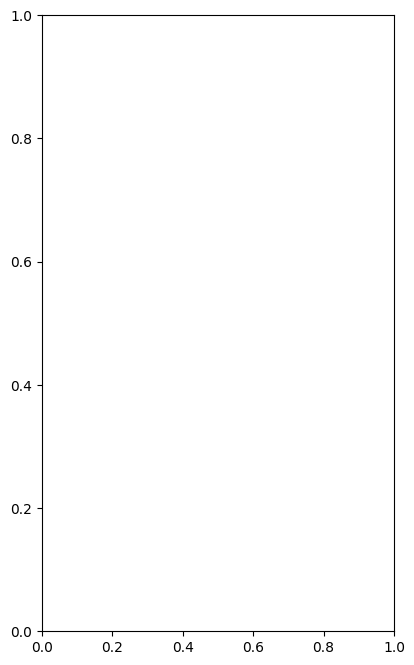

In [6]:
plt.subplot(1, 2, 1)
plt.hist(p2["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='red', label = 'not radial')   
plt.hist(p1["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='black', label = 'radial')  
plt.xlim(np.quantile(p1["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(p1["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
plt.xlabel('value')
plt.title("Distribution of velocity values in fluid region without outliers - radial")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(p2["u"][np.where(temporal_mask !=0)].flatten() - p1["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='blue', label = 'difference')  
plt.xlim(np.quantile(p1["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(p1["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
plt.xlabel('value')
plt.title("Difference")
plt.legend()

In [ ]:
data_dir = '../data/CARDIAC'
    
# ---- Patch index files ----
training_file = '{}/Temporal14MODEL12_2mm_step2.csv'.format(data_dir)

# Hyperparameters optimisation variables
epochs =  1
batch_size =10

patch_size = 14
res_increase = 2


# Load data file and indexes
trainset = load_indexes(training_file)

# ----------------- TensorFlow stuff -------------------
# TRAIN dataset iterator
z = PatchHandler4D(data_dir, patch_size, res_increase, batch_size)
trainset = z.initialize_dataset(trainset, shuffle=False, n_parallel=2)

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}")
    start_time = time.time()
    for i, data_pairs in enumerate(trainset):
        start_loop = time.time()
        
        a = data_pairs
        #check if datapairs align
        lr_u, hr_u_mask, mask = check_compatibility(a)

        message = f"Iteration {i+1}   - batch {time.time()-start_loop:.4f} sec {time.time()-start_time:.1f} secs"
        print(f"\r{message}", end='')
        print(' ________________________')
        #break
        
print("\nDone")#


In [ ]:
#show_timeframes(gt,lr,  pred,mask, rel_error, dt,  timepoints, axis, idx, save_as = "Frame_comparison.png")
# check interpolation result


p1 = lr['u']
p2 = interpolate_linear['u'] #temporal_linear_interpolation(lr["u"],gt["u"].shape)
p3 = interpolate_linear['v']#temporal_cubic_interpolation(lr["u"],gt["u"].shape)
p4 = p2.copy()
#p3[::2, :, :, :] -= p1
p4 -= p3
print("shapes_", p1.shape, p2.shape, p3.shape)

# min_v = -1#np.min(hr_u_downsampled)
# max_v = 1#np.max(hr_u_downsampled)
# #p3[np.where(p3 !=0)] = 1


@widgets.interact(frame=(0, p2.shape[0]-1), x = (0, p2.shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 4, 1)
    #plt.imshow(p1[frame//2, x, :, :])#, vmin=min_v, vmax= max_v)
    if frame%2 == 0:
        plt.imshow(p1[frame//2, x, :, :])#,  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    else:
        plt.imshow(np.zeros_like(p1[frame//2, x, :, :]))#, vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("LR")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(p2[frame, x, :, :])#, vmin=min_v, vmax= max_v)
    plt.title("Linear interpolation")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(p3[frame, x, :, :])#, vmin=min_v, vmax= max_v)
    plt.title("Cubic interpolation")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(p4[frame, x, :, :])#, vmin=min_v, vmax= max_v, cmap='gray')
    plt.title("Difference")
    plt.axis('off')
    plt.tight_layout()
    plt.show()



shapes_ (25, 62, 58, 84) (50, 62, 58, 84) (50, 62, 58, 84)


interactive(children=(IntSlider(value=5, description='frame', max=49), IntSlider(value=0, description='x', max…

In [ ]:
p1 = mask
p2 = hr_u_mask
p3 = mask-hr_u_mask
print("shapes_", p1.shape, p2.shape, p3.shape)

min_v = -1#np.min(hr_u_downsampled)
max_v = 1#np.max(hr_u_downsampled)
#p3[np.where(p3 !=0)] = 1
overlap_masks = np.count_nonzero(p3)
print("Check compatibility of masks! Nonzero difference:", overlap_masks, '/', np.prod(list(hr_u_mask.shape)), 'i.e. ', 100*overlap_masks/np.prod(np.array(hr_u_mask.shape)) ,"%") 


@widgets.interact(frame=(0, p1.shape[0]-1), x = (0, p1.shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 3, 1)
    plt.imshow(p1[frame, x, :, :], vmin=min_v, vmax= max_v)
    plt.title('Gt mask')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(p2[frame, x, :, :], vmin=min_v, vmax= max_v)
    plt.title("Non zero values for hr data")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(p3[frame, x, :, :], vmin=min_v, vmax= max_v, cmap='gray')
    plt.title("Difference")
    plt.axis('off')
    plt.tight_layout()
    plt.show()